# Wide Receiver Career Statistics Analysis
## Goal: To analyze the career statistics of wide receivers in the National Football Leage. All data is scraped from https://www.pro-football-reference.com. This data is scraped and stored in SQLite databases on my computer. 

### The database I put together has wide receivers whose last year was prior to 1994 and wide receivers who have data on Pro football Reference. Many of the players who are not included have negligible statistics or have not played in enough games to have a page on the website that I was able to scrape. Additionally, 1994 was the first year that statistics like first downs and targets were tracked. 

### 1. Our first step will be to just take a look at the data we have.

In [64]:
from read_from_db import read_all_from_db

In [65]:
df = read_all_from_db(abs_path="/Users/nickblackmore/personal_projects/sportscrape/sportscrape/core/Databases/NFL.db",
                     table='nfl_wrs_1994')
df.head()

index  GS  Tgt  Rec   Yds   Y/R  TD   1D Lng  R/G   Y/G  Ctch% Y/Tgt  \
0      0       25   13   163  12.5   0    7  32  0.6   7.4  52.0%   6.5   
1      0   2   40   21   203   9.7   0    9  21  0.9   8.5  52.5%   5.1   
2      0  85  763  484  5869  12.1  52  289  66  5.3  63.8  63.4%   7.7   
3      0        8    2    26  13.0   0    2  13  0.7   8.7  25.0%   3.3   
4      0        2    1     9   9.0   0    0   9  0.5   4.5  50.0%   4.5   

               Name HOF  
0  Jared Abbrederis  No  
1     Charlie Adams  No  
2     Davante Adams  No  
3        Kris Adams  No  
4    James Adkisson  No

In [66]:
df['Name'] = df['Name'].str.strip()
df.drop_duplicates(['Name'], inplace=True) #Preventative measure in case any values were duplicated in the database
df.set_index('Name', inplace=True)
df.drop(['index', 'Lng', 'Y/R', 'R/G', 'Y/G', 'Ctch%', 'Y/Tgt'], axis=1, inplace=True)
df.head()

GS  Tgt  Rec   Yds  TD   1D HOF
Name                                             
Jared Abbrederis       25   13   163   0    7  No
Charlie Adams      2   40   21   203   0    9  No
Davante Adams     85  763  484  5869  52  289  No
Kris Adams              8    2    26   0    2  No
James Adkisson          2    1     9   0    0  No

In [67]:
import seaborn as sns; sns.set(style="ticks", color_codes=True)
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [68]:
df.loc['Calvin Johnson']

GS       130
Tgt     1312
Rec      731
Yds    11619
TD        83
1D       552
HOF       No
Name: Calvin Johnson, dtype: object

In [69]:
df[df.columns[0:6]] = df[df.columns[0:6]].apply(pd.to_numeric)
print(df.dtypes)

GS     float64
Tgt      int64
Rec      int64
Yds      int64
TD       int64
1D       int64
HOF     object
dtype: object


### 2. Next we will try to visualize the data and see how the variables relate to one another. We will also replace the null values in the "Games Started" column with zeros. Much of the pre-processing of the data was done in the data scraping model, so there will not be as much of that here.

/Users/nickblackmore/opt/anaconda3/lib/python3.8/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


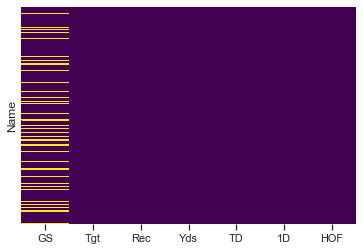

In [70]:
df.where(df != "", None)
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [71]:
df["GS"] = df["GS"].fillna(0)

In [72]:
from sklearn.preprocessing import StandardScaler
#Since the all of the features by definition have different units, the data must be standardized with the unit 
#variance. Otherwise, when we perform PCA, the first principal component would be affected by the 'Yds' column--
#the column with the most variance.

def standardize(dataframe):
    new_df = dataframe.copy()
    new_df[["GS","Tgt","Rec","Yds","TD","1D"]] = StandardScaler().fit_transform(new_df[["GS","Tgt","Rec","Yds","TD","1D"]])
    return new_df

standardized_df = standardize(df)
standardized_df.head()

GS       Tgt       Rec       Yds        TD        1D  \
Name                                                                           
Jared Abbrederis -0.692068 -0.657582 -0.647362 -0.641810 -0.625890 -0.615231   
Charlie Adams    -0.647882 -0.615579 -0.611928 -0.629002 -0.625890 -0.600591   
Davante Adams     1.185843  1.408943  1.438807  1.185220  1.848787  1.449049   
Kris Adams       -0.692068 -0.705184 -0.696084 -0.685677 -0.625890 -0.651832   
James Adkisson   -0.692068 -0.721985 -0.700513 -0.691120 -0.625890 -0.666472   

                 HOF  
Name                  
Jared Abbrederis  No  
Charlie Adams     No  
Davante Adams     No  
Kris Adams        No  
James Adkisson    No

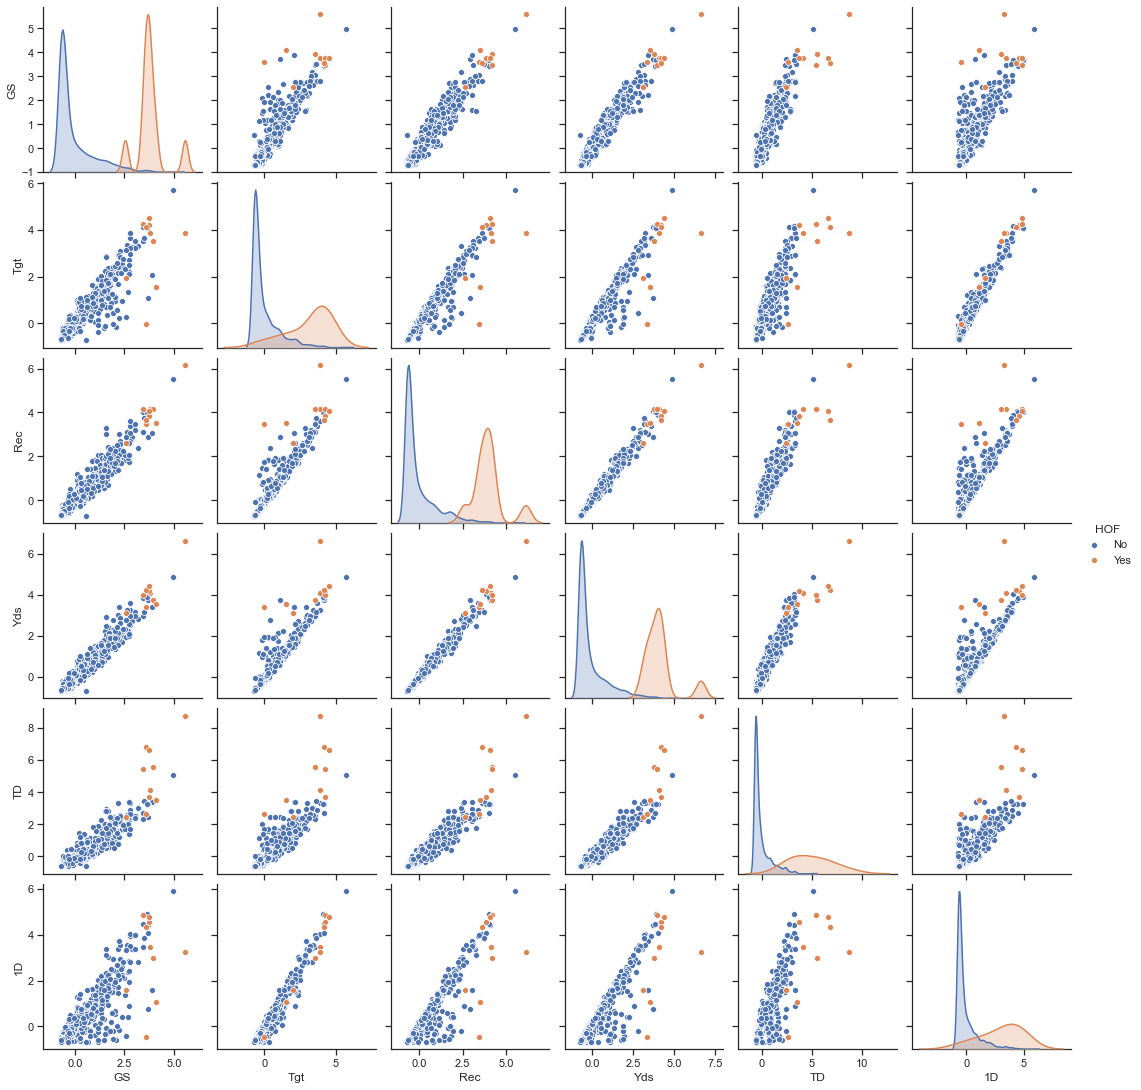

In [73]:
sns.pairplot(standardized_df, hue="HOF")

### 3. Now we will use pricnipal component analysis to reduce the dimensions of our data. This will be used both to visualize and cluster our data. 

In [74]:
from sklearn import decomposition

In [75]:
def pca_conversion(dataframe):
    
    X1 = standardized_df[["GS","Tgt","Rec","Yds","TD","1D"]]
    Y1 = list(df["HOF"])

    pca = decomposition.PCA(n_components=2)
    pc = pca.fit_transform(X1)
    pc_df = pd.DataFrame(data = pc, columns=["PC1", 'PC2'], index=dataframe.index)
    pc_df["HOF"] = Y1
    
    return pc_df, pca

pc_df, pca = pca_conversion(standardized_df)
pc_df.head()

PC1       PC2 HOF
Name                                    
Jared Abbrederis -1.584136 -0.017303  No
Charlie Adams    -1.523078 -0.022191  No
Davante Adams     3.473236  0.004797  No
Kris Adams       -1.656677  0.012059  No
James Adkisson   -1.673521  0.027405  No

In [76]:
print(pca.explained_variance_ratio_)

[0.95530203 0.02676955]


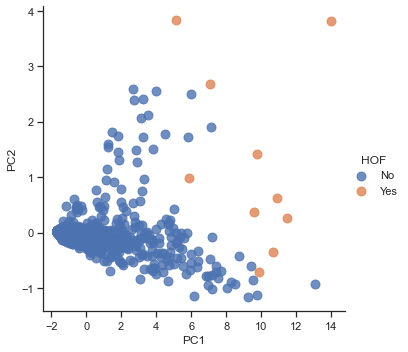

In [77]:
def plot_pca(pca_df):
    return sns.lmplot( x="PC1", y="PC2",
      data=pca_df, 
      fit_reg=False, 
      hue='HOF', 
      legend=True,
      scatter_kws={"s": 80}) 

plot_pca(pc_df)

### 4. We can clearly see from the pairplot that Hall of Fame players have in general higher stats than players that do not. We can also see that while the feautures appear to highly correlated with one another (due to PC1 accounting for 99.8% of the variance in the data) , none of them are normally distributed. Because of this, and because the sample size for the Hall of Fame players is considerable less than that of the non-Hall of Fame players, we will use non-parametric tests to determine how signifcantly every prediction feature differs between Hall of Fame and non-Hall of Fame players.

In [78]:
df["HOF"].value_counts()

No     1005
Yes      10
Name: HOF, dtype: int64

### Before we apply any statistical tests or models, we have to address another complication. Some hall of fame caliber players simply haven't been voted into the hall of fame yet because they are either still playing or not enough time has elapsed since the end of their careers for them to be voted in. To work around this, we will change the value in the "HOF" column to "yes" for some of the sure-fire hall of famers that haven't been voted in yet (Larry Fitzgerald, Calvin Johnson, etc.). This of course is subjective and is based on my own predictions of who the "sure-fire" hall of famers are. 

In [79]:
print(df[df['HOF']== 'Yes'])

                    GS   Tgt   Rec    Yds   TD   1D  HOF
Name                                                    
Tim Brown        202.0  1643  1094  14934  100  566  Yes
Isaac Bruce      201.0  1770  1024  15208   91  713  Yes
Cris Carter      209.0  1515  1101  13899  130  499  Yes
Marvin Harrison  188.0  1781  1102  14580  128  756  Yes
Michael Irvin    147.0   960   750  11904   65  309  Yes
Art Monk         194.0   241   940  12721   68   28  Yes
Randy Moss       193.0  1741   982  15292  156  684  Yes
Terrell Owens    201.0  1867  1078  15934  153  747  Yes
Andre Reed       217.0   809   951  13198   87  240  Yes
Jerry Rice       284.0  1640  1549  22895  197  537  Yes


In [80]:
future_hof = ["Larry Fitzgerald", "Calvin Johnson", "Andre Johnson", "Steve Smith", "Isaac Bruce"]
for player in future_hof:
    df.loc[player, "HOF"] = "Yes"
    
print(df[df['HOF']== 'Yes'])


                     GS   Tgt   Rec    Yds   TD   1D  HOF
Name                                                     
Tim Brown         202.0  1643  1094  14934  100  566  Yes
Isaac Bruce       201.0  1770  1024  15208   91  713  Yes
Cris Carter       209.0  1515  1101  13899  130  499  Yes
Larry Fitzgerald  256.0  2305  1411  17344  120  897  Yes
Marvin Harrison   188.0  1781  1102  14580  128  756  Yes
Michael Irvin     147.0   960   750  11904   65  309  Yes
Andre Johnson     187.0  1739  1062  14185   70  701  Yes
Calvin Johnson    130.0  1312   731  11619   83  552  Yes
Art Monk          194.0   241   940  12721   68   28  Yes
Randy Moss        193.0  1741   982  15292  156  684  Yes
Terrell Owens     201.0  1867  1078  15934  153  747  Yes
Andre Reed        217.0   809   951  13198   87  240  Yes
Jerry Rice        284.0  1640  1549  22895  197  537  Yes
Steve Smith       198.0  1748  1031  14731   81  648  Yes


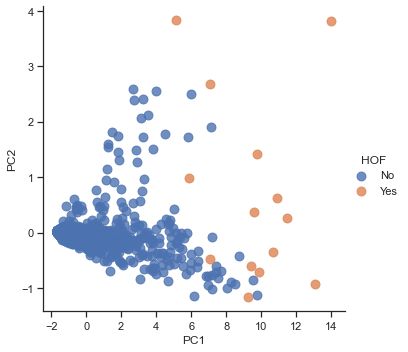

In [81]:
new_standard_df, _ = pca_conversion(standardize(df))
new_standard_df.head()
plot_pca(new_standard_df)

In [82]:
new_standard_df.head()

PC1       PC2 HOF
Name                                    
Jared Abbrederis -1.584136 -0.017303  No
Charlie Adams    -1.523078 -0.022191  No
Davante Adams     3.473236  0.004797  No
Kris Adams       -1.656677  0.012059  No
James Adkisson   -1.673521  0.027405  No

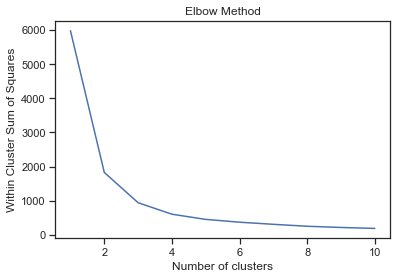

In [83]:
from sklearn.cluster import KMeans

cluster_sum_squares = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(new_standard_df[['PC1', 'PC2']])
    cluster_sum_squares.append(kmeans.inertia_)

plt.plot(range(1, 11), cluster_sum_squares)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Within Cluster Sum of Squares')
plt.show()

### 5. Here we use the elbow method to visualize the "within cluster sum of squares" for different numbers of clusters. We will now train fit the k-means model with three clusters.

In [84]:
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)
output = kmeans.fit(new_standard_df[['PC1', 'PC2']])

kmeans_df = new_standard_df
kmeans_df['cluster_labels'] = output.labels_
kmeans_df['cluster_labels'] =  kmeans_df['cluster_labels'].astype('category')
print(kmeans_df.dtypes)

PC1                float64
PC2                float64
HOF                 object
cluster_labels    category
dtype: object


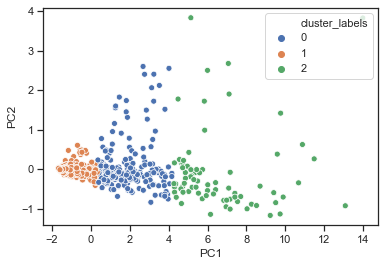

In [85]:
sns.scatterplot(x='PC1', y='PC2', hue="cluster_labels", data=kmeans_df, legend="full")

### As we can see from the clusters, this actually gives us a pretty good idea of the three types of wide recievers based on their career statistics: (Cluster 1) below average players that didn't not play or accumulate very many statistics; (Cluster 0) players that had decent yet un-spectacular careers; and (Cluster 2) players that have above average careers. Below I will compute the percentage of players in each cluster that were elected into the hall of fame. 

### 6. In this last step we will read in data froma new table. This DataFrame contains each player's stats for each individual year they played, rather than containing just one row of their career statistics. Using this data, we can identify which season long performances were worthy of pro-bowl selections. Using logistic regression, we can create a model that is trained on historic data. We will then back-test the data to see what season long statistics are deemed pro-bowl level seasons by the model.

In [100]:
annual_df = read_all_from_db(abs_path="/Users/nickblackmore/personal_projects/sportscrape/sportscrape/core/Databases/NFL.db",
                     table='nfl_wrs_1994_annual')

In [101]:
annual_df.dtypes

index     int64
Year     object
Age      object
Tm       object
Pos      object
No.      object
G        object
GS       object
Tgt      object
Rec      object
Yds      object
Y/R      object
TD       object
1D       object
Lng      object
R/G      object
Y/G      object
Ctch%    object
Y/Tgt    object
name     object
dtype: object

In [102]:
#this function will be used create a column indicating whether a certain season was a pro-bowl or all-pro season
def pro_bowl(year):
    if "*" in year:
        return "Yes"
    else:
        return "No"
    
annual_df['Pro Bowl'] = annual_df['Year'].apply(pro_bowl)
annual_df['Pro Bowl'].value_counts()
    

No     4728
Yes     352
Name: Pro Bowl, dtype: int64

In [103]:
annual_df.columns

Index(['index', 'Year', 'Age', 'Tm', 'Pos', 'No.', 'G', 'GS', 'Tgt', 'Rec',
       'Yds', 'Y/R', 'TD', '1D', 'Lng', 'R/G', 'Y/G', 'Ctch%', 'Y/Tgt', 'name',
       'Pro Bowl'],
      dtype='object')

In [104]:
#REmoving other non numeric characters from the Year column
annual_df['Year'] = annual_df['Year'].str[0:4]
annual_df['Ctch%'] = annual_df['Ctch%'].str[0:-1]

#revising the dataframe so that all numeric columns are in fact numeric
annual_df[[ 'Year', 'Age', 'G', 'GS', 'Tgt', 'Rec',
       'Yds', 'Y/R', 'TD', '1D', 'Lng', 'R/G', 'Y/G', 'Ctch%', 'Y/Tgt']] = \
annual_df[[ 'Year', 'Age', 'G', 'GS', 'Tgt', 'Rec', 'Yds', 'Y/R', 'TD', '1D', 'Lng', 'R/G', 
                         'Y/G', 'Ctch%', 'Y/Tgt']].apply(pd.to_numeric)

annual_df.dtypes

index         int64
Year          int64
Age           int64
Tm           object
Pos          object
No.          object
G           float64
GS          float64
Tgt         float64
Rec         float64
Yds         float64
Y/R         float64
TD          float64
1D          float64
Lng         float64
R/G         float64
Y/G         float64
Ctch%       float64
Y/Tgt       float64
name         object
Pro Bowl     object
dtype: object

In [105]:
#Converting pro bowl column to a categorical value then creating a new column of the binary value
annual_df['Pro Bowl'] = annual_df['Pro Bowl'].astype('category')
annual_df['target'] = annual_df['Pro Bowl'].cat.codes
annual_df['target'].value_counts()

0    4728
1     352
Name: target, dtype: int64

In [106]:
#Splitting targets, features, and training and testing. We will also standardize the features like we did in part 1
#since the all have different units
from sklearn.model_selection import train_test_split

feature_cols = ['G', 'GS', 'Tgt', 'Rec',
       'Yds', 'Y/R', 'TD', '1D', 'Lng', 'R/G', 'Y/G', 'Ctch%', 'Y/Tgt']

X = annual_df[feature_cols].fillna(0)
X = StandardScaler().fit_transform(X)
y = annual_df['target']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.33,random_state=0)

In [107]:
#First I will create a simple logistic regression model based on all available data
from sklearn.linear_model import LogisticRegression

logistic_regression= LogisticRegression()
logistic_regression.fit(X_train,y_train)
y_pred=logistic_regression.predict(X_test)

Accuracy:  0.9505068574836016


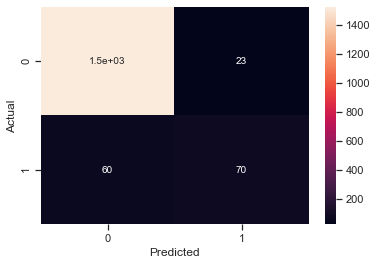

In [108]:
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn import metrics

confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix, annot=True)

print('Accuracy: ',metrics.accuracy_score(y_test, y_pred))
plt.show()

In [109]:
#Taking a look at what this model gets wrong when back-tested on the entire dataset
def prob_score(features):
    prob = logistic_regression.predict_proba([features]).max()
    
    return prob

def target_class(features):
    prediction = logistic_regression.predict([features])
    
    return prediction[0]


transformed = annual_df.copy()
annual_df_prediction = annual_df.copy()

transformed[feature_cols] = transformed[feature_cols].fillna(0)
transformed[feature_cols] = StandardScaler().fit_transform(transformed[feature_cols])
annual_df_prediction['Probs'] = transformed[feature_cols].apply(prob_score, axis=1)
annual_df_prediction['Predictions'] = transformed[feature_cols].apply(target_class, axis=1)
annual_df_prediction.head()

index  Year  Age   Tm Pos No.     G   GS   Tgt  Rec  ...   Lng  R/G   Y/G  \
0      0  2014   24  GNB           0.0  NaN   NaN  0.0  ...   0.0  NaN   NaN   
1      1  2015   25  GNB      84  10.0  0.0  16.0  9.0  ...  32.0  0.9  11.1   
2      2  2016   26  GNB      84   5.0  0.0   2.0  1.0  ...   8.0  0.2   1.6   
3      3  2017   27  DET      10   7.0  0.0   7.0  3.0  ...  25.0  0.4   6.3   
4      0  2003   24  DEN      12   4.0  0.0   4.0  0.0  ...   0.0  0.0   0.0   

   Ctch%  Y/Tgt              name  Pro Bowl  target     Probs Predictions  
0    0.0    NaN  Jared Abbrederis        No       0  0.998583           0  
1   56.3    6.9  Jared Abbrederis        No       0  0.999550           0  
2   50.0    4.0  Jared Abbrederis        No       0  0.999534           0  
3   42.9    6.3  Jared Abbrederis        No       0  0.999842           0  
4    0.0    0.0     Charlie Adams        No       0  0.997621           0  

[5 rows x 24 columns]

In [110]:
#The cell above applies the logistic regression model we created to every year in the dataset, predicts the class it
#belows to, and the probability, based on the model, that it belongs to that class. 

In [111]:
#Now we will look at the seasons where Pro Bowl equals 0 and predicitons equals 1. This returns seasons where a
#player didn't make the pro bowl, but according to our model they should have. I we sort by the "Probs" column in
#descending order, we will get the seasons that most pro bowl worthy acording to our model, but did not make the pro
#bowl

snubs = annual_df_prediction[(annual_df_prediction['target'] == 0) & (annual_df_prediction['Predictions'] == 1)]
snubs.sort_values(by='Probs', ascending=False).head(20)

index  Year  Age   Tm Pos No.     G    GS    Tgt    Rec  ...   Lng  R/G  \
623       1  1995   23  STL  WR  80  16.0  16.0  199.0  119.0  ...  72.0  7.4   
3991      2  1988   28  WAS      83  16.0   4.0    NaN   73.0  ...  55.0  4.6   
519       3  1995   25  GNB  WR  87  16.0  16.0  167.0  102.0  ...  99.0  6.4   
1099      1  2011   25  NYG  wr  80  16.0   7.0  131.0   82.0  ...  99.0  5.1   
3217      9  1989   32  WAS  WR  81  16.0  12.0    NaN   86.0  ...  60.0  5.4   
887       4  1989   27  WAS  WR  84  15.0  12.0    NaN   79.0  ...  80.0  5.3   
3439      7  2016   31  GNB  WR  87  16.0  16.0  152.0   97.0  ...  60.0  6.1   
3615      7  1995   30  DET  WR  80  16.0  16.0  179.0  108.0  ...  91.0  6.8   
647       2  2012   24  DAL  WR  88  16.0  14.0  138.0   92.0  ...  85.0  5.8   
382       2  2005   25  ARI  WR  81  14.0  14.0  171.0  102.0  ...  54.0  7.3   
3895      1  1999   24  CHI  WR  88  16.0  11.0  149.0   84.0  ...  80.0  5.3   
970       1  2007   24  NOR  WR  12  16.0  14.0  143.0   98.0  ...  45.0  6.1   
1362      7  1990   29  RAM  WR  80  15.0  15.0    NaN   76.0  ...  50.0  5.1   
3506     10  2006   33  DAL  WR  81  16.0  15.0  150.0   85.0  ...  56.0  5.3   
1618      5  2013   27  WAS  WR  88  16.0  16.0  181.0  113.0  ...  53.0  7.1   
3353     11  2009   32  NWE  WR  81  16.0  16.0  137.0   83.0  ...  71.0  5.2   
3027      9  2000   32  DEN  WR  87  16.0  16.0  149.0  101.0  ...  61.0  6.3   
1202      3  2013   26  DEN  WR  87  16.0  16.0  136.0   87.0  ...  61.0  5.4   
3435      3  2011   26  GNB  WR  87  16.0   9.0   96.0   68.0  ...  93.0  4.3   
2471      1  2008   23  DET  WR  81  16.0  16.0  150.0   78.0  ...  96.0  4.9   

        Y/G  Ctch%  Y/Tgt             name  Pro Bowl  target     Probs  \
623   111.3   59.8    8.9      Isaac Bruce        No       0  0.991602   
3991   71.8    NaN    NaN   Ricky Sanders         No       0  0.957856   
519    93.6   61.1    9.0   Robert Brooks         No       0  0.899614   
1099   96.0   62.6   11.7      Victor Cruz        No       0  0.850834   
3217   74.1    NaN    NaN         Art Monk        No       0  0.845090   
887    81.9    NaN    NaN       Gary Clark        No       0  0.844404   
3439   78.6   63.8    8.3     Jordy Nelson        No       0  0.837166   
3615   93.0   60.3    8.3   Brett Perriman        No       0  0.826434   
647    86.4   66.7   10.0       Dez Bryant        No       0  0.820070   
382   100.1   59.6    8.2    Anquan Boldin        No       0  0.809568   
3895   87.5   56.4    9.4  Marcus Robinson        No       0  0.782945   
970    75.1   68.5    8.4  Marques Colston        No       0  0.743362   
1362   86.3    NaN    NaN     Henry Ellard        No       0  0.734087   
3506   73.8   56.7    7.9    Terrell Owens        No       0  0.716726   
1618   84.1   62.4    7.4    Pierre Garcon        No       0  0.704153   
3353   79.0   60.6    9.2       Randy Moss        No       0  0.680227   
3027   82.3   67.8    8.8     Ed McCaffrey        No       0  0.677777   
1202   80.5   64.0    9.5      Eric Decker        No       0  0.660011   
3435   78.9   70.8   13.2     Jordy Nelson        No       0  0.659655   
2471   83.2   52.0    8.9  Calvin Johnson         No       0  0.658700   

     Predictions  
623            1  
3991           1  
519            1  
1099           1  
3217           1  
887            1  
3439           1  
3615           1  
647            1  
382            1  
3895           1  
970            1  
1362           1  
3506           1  
1618           1  
3353           1  
3027           1  
1202           1  
3435           1  
2471           1  

[20 rows x 24 columns]

### We can see that this version of the model achieves around 96 percent accuracy. From here we will look at some feature selection techniques train the model. We will also try holding out the 2019 season to see how the model performs, and see if there were any snubs.